<a href="https://colab.research.google.com/github/segravjf/python_practice/blob/main/retention_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retention Analysis

Given the following [dataset](https://raw.githubusercontent.com/erood/interviewqs.com_code_snippets/master/Datasets/online_retail.csv), can you create a retention chart similar to the one shown in this [picture](https://mode.com/help/images/mode-playbook/describing-retention-update.png)? In the picture, each row on the chart represents a user's sign up month and each numeric column represents the percent of users that are still "active".

In [1]:
## Import packages
import numpy as np
import pandas as pd
import matplotlib as mat
import seaborn as sns

In [2]:
## Import dataset
df_raw = pd.read_csv('https://raw.githubusercontent.com/erood/interviewqs.com_code_snippets/master/Datasets/online_retail.csv')

df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [3]:
df_raw.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [4]:
## Create a column with the CustomerID and the first InvoiceDate
print(max(df_raw['InvoiceDate']))
print(min(df_raw['InvoiceDate']))

df = df_raw.copy()
df['FirstOfMonth'] = df_raw['InvoiceDate'].astype('datetime64[M]')

df.head()

9/9/11 9:52
1/10/11 10:04


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FirstOfMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom,2010-12-01


In [5]:
## Create a df with CustomerID and the first date they made a purchase
CID_group = df.groupby(['CustomerID'])
first_purchase = CID_group.agg(First_Date=('FirstOfMonth',np.min)).reset_index()

first_purchase.head()

,CustomerID,First_Date
0,12346.0,2011-01-01
1,12347.0,2010-12-01
2,12348.0,2010-12-01
3,12349.0,2011-11-01
4,12350.0,2011-02-01


In [6]:
## Aggregate up Purchases by CustomerID and first of month, then merge in the first date df, then aggregate up
CID_firstmonth = df.groupby(['CustomerID','FirstOfMonth']).count().reset_index()

## Merge in first date df
merged = pd.merge(left=CID_firstmonth, right=first_purchase, on=['CustomerID'],how='inner')

## Aggregate up at the First_Date, then FirstOfMonth
purchase_months = merged.groupby(['First_Date','FirstOfMonth'])['CustomerID'].count().reset_index()
purchase_months.head(15)

,First_Date,FirstOfMonth,CustomerID
0,2010-12-01,2010-12-01,948
1,2010-12-01,2011-01-01,362
2,2010-12-01,2011-02-01,317
3,2010-12-01,2011-03-01,367
4,2010-12-01,2011-04-01,341
5,2010-12-01,2011-05-01,376
6,2010-12-01,2011-06-01,360
7,2010-12-01,2011-07-01,336
8,2010-12-01,2011-08-01,336
9,2010-12-01,2011-09-01,374


In [7]:
## Get max of each First_Date to get the denominator for the heatmap values
max_custs_by_date = purchase_months.groupby(['First_Date']).agg(Max_Custs = ('CustomerID', np.max)).reset_index()
purchase_months_w_denom = pd.merge(left=purchase_months,right=max_custs_by_date)
purchase_months_w_denom['pct_retained'] = purchase_months_w_denom['CustomerID'] * 1.0 / purchase_months_w_denom['Max_Custs']

## Get the months since First_Date
purchase_months_w_denom['Months_Since_First_Purchase'] = (purchase_months_w_denom.FirstOfMonth - purchase_months_w_denom.First_Date) / np.timedelta64(1, 'M')
purchase_months_w_denom['Months_Since_First_Purchase'] = purchase_months_w_denom.Months_Since_First_Purchase.round(0).astype(int)

purchase_months_w_denom.head(15)

,First_Date,FirstOfMonth,CustomerID,Max_Custs,pct_retained,Months_Since_First_Purchase
0,2010-12-01,2010-12-01,948,948,1.000000,0
1,2010-12-01,2011-01-01,362,948,0.381857,1
2,2010-12-01,2011-02-01,317,948,0.334388,2
3,2010-12-01,2011-03-01,367,948,0.387131,3
4,2010-12-01,2011-04-01,341,948,0.359705,4
5,2010-12-01,2011-05-01,376,948,0.396624,5
6,2010-12-01,2011-06-01,360,948,0.379747,6
7,2010-12-01,2011-07-01,336,948,0.354430,7
8,2010-12-01,2011-08-01,336,948,0.354430,8
9,2010-12-01,2011-09-01,374,948,0.394515,9


In [8]:
## Remove the first month from the dataset as it'll always look like 100%
remove_zeros = purchase_months_w_denom[purchase_months_w_denom['Months_Since_First_Purchase'] > 0]
remove_zeros.First_Date = remove_zeros.First_Date.dt.date

## Pivot for use in seaborn
heat = remove_zeros.pivot(index='First_Date',columns='Months_Since_First_Purchase',values='pct_retained')

heat

<ipython-input-8-e780508eec8c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_zeros.First_Date = remove_zeros.First_Date.dt.date


Months_Since_First_Purchase,1,2,3,4,5,6,7,8,9,10,11,12
First_Date,,,,,,,,,,,,
2010-12-01,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01-01,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02-01,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03-01,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04-01,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05-01,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06-01,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


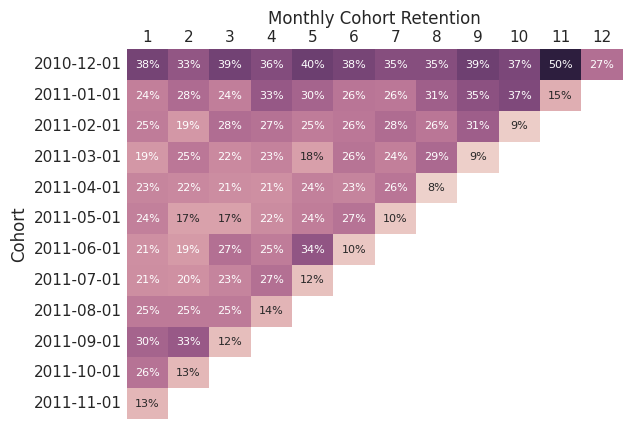

In [9]:
import matplotlib.pyplot as plt

## Display heat map
sns.set_theme(style='white')
ax = sns.heatmap(data=heat, cmap=sns.cubehelix_palette(as_cmap=True), annot = True, fmt='.0%', annot_kws={'size':8}, cbar=False)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(length=0)
ax.set(xlabel = "Monthly Cohort Retention", ylabel = 'Cohort')

plt.show()